In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Домашнее задание

1. обучить рукописную сверточную нейронную сеть (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете cifar-10
2. оценить рост точности при увеличении ширины сети (больше фильтров)
3. оценить рост точности при увеличении глубины сети (больше слоев)
4. *сравнить с точностью полносвязной сети для этой выборки

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

import os

In [3]:
tf.random.set_seed(1)

In [4]:
tf.config.list_physical_devices('GPU')

2022-11-29 11:55:13.673731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 11:55:13.758159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 11:55:13.758954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
results = pd.DataFrame() # сводная таблица результатов
step = [] # шаг
desc = [] # описание
train_acc = [] # результат на трейне
test_acc = ['test_acc'] # результат на тесте

In [6]:
# установка параметров нейросети
batch_size = 64
num_classes = 10
epochs = 10

# разделение тренировочной и тестовой выборки
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


X_train = X_train / 255.0
X_test = X_test / 255.0

170508288/170498071 [==============================] - 12s 0us/step
X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [7]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

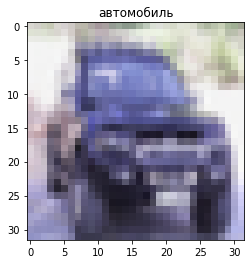

In [8]:
N = 9

plt.imshow(X_test[N])
plt.title(classes[np.argmax(y_test[N, :])])
plt.show()

In [9]:
# конфигурирование слоев нейросети
model_1 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_1.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_1.add(Activation('relu'))
model_1.add(Conv2D(32, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(64, (3, 3), padding='same'))
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# полносвязные слои нейронной сети
model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(64))
model_1.add(Activation('relu'))
model_1.add(Dense(32))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

model_1.summary()
# компиляция модели
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

2022-11-29 11:55:30.483172: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 11:55:30.483646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 11:55:30.484563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-29 11:55:30.485242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [10]:
history_1 = model_1.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

2022-11-29 11:55:35.254632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-29 11:55:36.742586: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


782/782 [==============================] - 12s 7ms/step - loss: 1.9668 - accuracy: 0.2310 - val_loss: 1.7030 - val_accuracy: 0.3347
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 1.7058 - accuracy: 0.3374 - val_loss: 1.5262 - val_accuracy: 0.4203
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 1.5721 - accuracy: 0.4001 - val_loss: 1.4383 - val_accuracy: 0.4633
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 1.4837 - accuracy: 0.4488 - val_loss: 1.2953 - val_accuracy: 0.5208
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 1.4182 - accuracy: 0.4775 - val_loss: 1.2276 - val_accuracy: 0.5504
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 1.3477 - accuracy: 0.5092 - val_loss: 1.1548 - val_accuracy: 0.5907
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 1.3009 - accuracy: 0.5350 - val_loss: 1.1049 - val_accuracy: 0.6055
Epoch 8/10
782/7

In [11]:
train_loss, train_m = model_1.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_1.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(1)
desc.append('Базовая модель')
train_acc.append(round(train_m, 2))
test_acc.append(round(test_m, 2))

1563/1563 - 4s - loss: 0.9345 - accuracy: 0.6635
313/313 - 1s - loss: 0.9863 - accuracy: 0.6439
train_loss: 0.934499204158783, train_accuracy: 0.6634799838066101
test_loss: 0.9863442182540894, test_accuracy: 0.6438999772071838


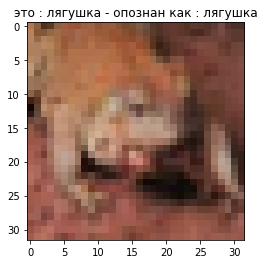

In [12]:
N = 5
y_p = model_1.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

In [13]:
# конфигурирование слоев нейросети
model_2 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_2.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(256, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

# полносвязные слои нейронной сети
model_2.add(GlobalAveragePooling2D())
model_2.add(Dense(64))
model_2.add(Activation('relu'))
model_2.add(Dense(32))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.summary()
# компиляция модели
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

In [14]:
history_2 = model_2.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Epoch 1/10
782/782 [==============================] - 8s 9ms/step - loss: 1.9672 - accuracy: 0.2364 - val_loss: 1.6760 - val_accuracy: 0.3513
Epoch 2/10
782/782 [==============================] - 7s 9ms/step - loss: 1.6208 - accuracy: 0.3919 - val_loss: 1.4477 - val_accuracy: 0.4639
Epoch 3/10
782/782 [==============================] - 7s 9ms/step - loss: 1.4596 - accuracy: 0.4714 - val_loss: 1.2544 - val_accuracy: 0.5402
Epoch 4/10
782/782 [==============================] - 7s 8ms/step - loss: 1.3555 - accuracy: 0.5145 - val_loss: 1.2167 - val_accuracy: 0.5501
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 1.2729 - accuracy: 0.5500 - val_loss: 1.0636 - val_accuracy: 0.6188
Epoch 6/10
782/782 [==============================] - 7s 8ms/step - loss: 1.1928 - accuracy: 0.5827 - val_loss: 1.0671 - val_accuracy: 0.6266
Epoch 7/10
782/782 [==============================] - 7s 9ms/step - loss: 1.1165 - accuracy: 0.6125 - val_loss: 0.9409 - val_accuracy: 0.6685
Epoch 

In [15]:
train_loss, train_m = model_2.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_2.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(2)
desc.append('Шире - больше каналов')
train_acc.append(round(train_m, 2))
test_acc.append(round(test_m, 2))

1563/1563 - 4s - loss: 0.7693 - accuracy: 0.7301
313/313 - 1s - loss: 0.8595 - accuracy: 0.7002
train_loss: 0.7693064212799072, train_accuracy: 0.7300999760627747
test_loss: 0.8595002889633179, test_accuracy: 0.7002000212669373


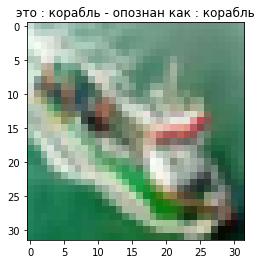

In [16]:
N = 15
y_p = model_2.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

In [17]:
# конфигурирование слоев нейросети
model_3 = Sequential()

# слои нейросети отвественные за свертку и max-pooling
model_3.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model_3.add(Activation('relu'))
model_3.add(Conv2D(32, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))


# полносвязные слои нейронной сети
model_3.add(GlobalAveragePooling2D())
model_3.add(Dense(64))
model_3.add(Activation('relu'))
model_3.add(Dense(32))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
model_3.add(Activation('softmax'))

model_3.summary()
# компиляция модели
model_3.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_15 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)       

In [18]:
history_3 = model_3.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Epoch 1/10
782/782 [==============================] - 6s 7ms/step - loss: 1.9612 - accuracy: 0.2370 - val_loss: 1.6560 - val_accuracy: 0.3740
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 1.6114 - accuracy: 0.3943 - val_loss: 1.3230 - val_accuracy: 0.5072
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 1.4089 - accuracy: 0.4953 - val_loss: 1.2307 - val_accuracy: 0.5666
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 1.2915 - accuracy: 0.5461 - val_loss: 1.1049 - val_accuracy: 0.5973
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 1.1915 - accuracy: 0.5874 - val_loss: 1.0301 - val_accuracy: 0.6285
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 1.1200 - accuracy: 0.6149 - val_loss: 0.9494 - val_accuracy: 0.6649
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 1.0659 - accuracy: 0.6362 - val_loss: 0.9164 - val_accuracy: 0.6887
Epoch 

In [19]:
train_loss, train_m = model_3.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_3.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(3)
desc.append('Глубже - больше слоев')
train_acc.append(round(train_m,2))

1563/1563 - 4s - loss: 0.6949 - accuracy: 0.7551
313/313 - 1s - loss: 0.8110 - accuracy: 0.7272
train_loss: 0.6949465870857239, train_accuracy: 0.7551199793815613
test_loss: 0.8110464811325073, test_accuracy: 0.7271999716758728


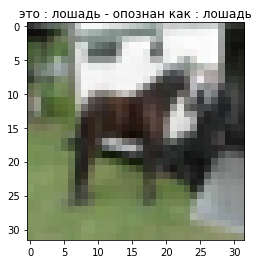

In [20]:
N = 20
y_p = model_3.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

In [21]:
# конфигурирование слоев нейросети
model_4 = Sequential()

# полносвязные слои нейронной сети
model_4.add(Flatten(input_shape=X_train.shape[1:]))
model_4.add(Dense(512))
model_4.add(Activation('relu'))
model_4.add(Dense(256))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(num_classes))
model_4.add(Activation('softmax'))

model_4.summary()
# компиляция модели
model_4.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1573376   
_________________________________________________________________
activation_23 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_24 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

In [22]:
history_4 = model_4.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 1.9846 - accuracy: 0.2772 - val_loss: 1.7569 - val_accuracy: 0.3725
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 1.7733 - accuracy: 0.3608 - val_loss: 1.6894 - val_accuracy: 0.3948
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 1.7115 - accuracy: 0.3867 - val_loss: 1.6135 - val_accuracy: 0.4287
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 1.6489 - accuracy: 0.4107 - val_loss: 1.6227 - val_accuracy: 0.4127
Epoch 5/10
782/782 [==============================] - 3s 3ms/step - loss: 1.6161 - accuracy: 0.4224 - val_loss: 1.5594 - val_accuracy: 0.4493
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 1.5883 - accuracy: 0.4339 - val_loss: 1.5481 - val_accuracy: 0.4459
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 1.5692 - accuracy: 0.4402 - val_loss: 1.5162 - val_accuracy: 0.4599
Epoch 

In [23]:
train_loss, train_m = model_4.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_4.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

step.append(4)
desc.append('Полносвязная сеть')
train_acc.append(round(train_m,2))
test_acc.append(round(test_m,2))

1563/1563 - 3s - loss: 1.4573 - accuracy: 0.4781
313/313 - 1s - loss: 1.5199 - accuracy: 0.4591
train_loss: 1.4572727680206299, train_accuracy: 0.4780600070953369
test_loss: 1.5199074745178223, test_accuracy: 0.45910000801086426


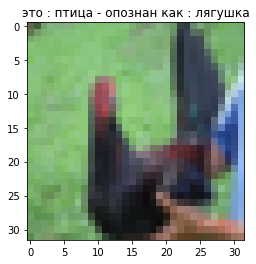

In [24]:
N = 25
y_p = model_4.predict(X_test[N:N+1])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(X_test[N])
plt.title(f'это : {classes[y_t[0]]} - опознан как : {classes[y_i[0]]}')
plt.show()

In [25]:
results['step'] = step
results['desc'] = desc
results['train_acc'] = train_acc
results['test_acc'] = test_acc
results

,step,desc,train_acc,test_acc
0,1,Базовая модель,0.66,test_acc
1,2,Шире - больше каналов,0.73,0.64
2,3,Глубже - больше слоев,0.76,0.7
3,4,Полносвязная сеть,0.48,0.46


### Вывод:

Базовая модель показала результаты: 0.66 0.65 (трейн/тест)

Увеличение количества каналов дало улучшение результатов до 0.72 0.70 (трейн/тест)

Увеличение числа слоев дало лучшее увеличение точности 0.75 0.72 (трейн/тест)

Полносвязная сеть дала результат хуже базовой модели 0.49 0.47 (трейн/тест)